In [72]:
from griddify import datasets

data = datasets.get_compound_descriptors()

In [73]:
from griddify import Preprocessing

pp  = Preprocessing()
pp.fit(data)
data = pp.transform(data)

In [74]:
from griddify import FeatureDistances

fd = FeatureDistances(metric="cosine").calculate(data)

In [75]:
from griddify import Tabular2Cloud


tc = Tabular2Cloud()
tc.fit(fd)
Xc = tc.transform(fd)


/home/mduranfrigola/miniconda3/envs/tab2grid/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [76]:
from griddify.plots import cloud_plot

<AxesSubplot:>

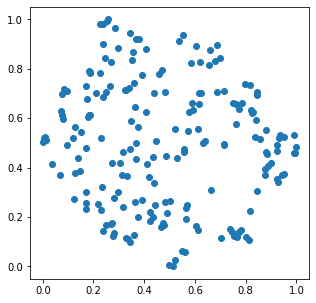

In [77]:
cloud_plot(Xc)

In [78]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
Xg = cg.transform(Xc, as_integers=False)

<AxesSubplot:>

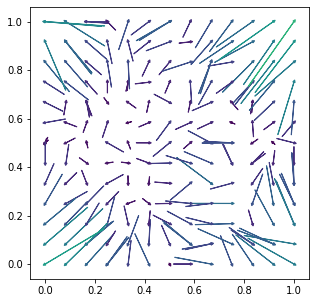

In [79]:
from griddify.plots import arrows_plot

arrows_plot(Xc, Xg, capping_distance=0.5)

In [81]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
mappings, side = cg.get_mappings(Xc)

AttributeError: 'Cloud2Grid' object has no attribute 'get_mappings'

In [49]:
from griddify import Flat2Grid

tg = Flat2Grid(mappings, side)
Xi = tg.transform(data)

<AxesSubplot:>

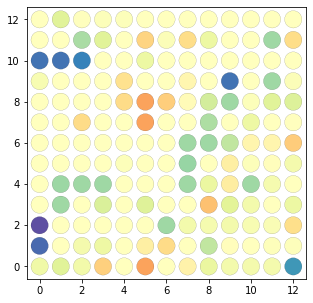

In [71]:
from griddify.plots import grid_plot

grid_plot(Xi[0])

In [58]:
import numpy as np
np.min(Xi)

-10.0